# Predicting Daily Market Movements with QDA
This experiment uses Quadratic Discriminant Analysis (QDA) to predict daily returns. The experiment starts by analyzing predictors and their relations with daily market movements. Data is then extracted and cleaned and the predictors are extracted from the data. Metrics are computed to determine the viability of the model, providing insghts into the model's fitting and performance. The model is then tested on in-sample and out-of-sample to determine the model's performance. To conclude the experiment, the strategy is simulated to see how the model would have performed historically.

In [163]:
# File imports
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.multivariate import test_cov_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import normaltest
from scipy.linalg import pinv
from scipy.stats import chi2

# Import ISLP-Specific Functions/Classes
from ISLP import confusion_table
from ISLP.models import(
    ModelSpec as MS,
    summarize
)

# Import settings
plt.style.use('ggplot')

### 1. Assessing Predictors and Responses
The predictors used for the QDA model are specified below.

In [164]:
t_data = yf.download('SPY', start='1980-01-01', interval='1d', auto_adjust=True)

# Re-format the yahoo finance data
data = pd.DataFrame()
data['Close'] = t_data['Close']
data['Volume'] = t_data['Volume']

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Daily return lags
data['Ret_Lag1'] = data['Returns'].shift(1)
data['Ret_Lag2'] = data['Returns'].shift(2)
data['Ret_Lag3'] = data['Returns'].shift(3)
data['Ret_Lag4'] = data['Returns'].shift(4)
data['Ret_Lag5'] = data['Returns'].shift(5)

# Daily volume lags
data['Vol_Lag1'] = data['Volume'].shift(1)
data['Vol_Lag2'] = data['Volume'].shift(2)
data['Vol_Lag3'] = data['Volume'].shift(3)
data['Vol_Lag4'] = data['Volume'].shift(4)
data['Vol_Lag5'] = data['Volume'].shift(5)

# Calculate the rolling volatility
data['volatility_1'] = data['Returns'].rolling(window=2).std()
data['volatility_2'] = data['Returns'].rolling(window=3).std()
data['volatility_3'] = data['Returns'].rolling(window=4).std()
data['volatility_4'] = data['Returns'].rolling(window=5).std()
data['volatility_5'] = data['Returns'].rolling(window=6).std()


# Clean the data
data.dropna(axis=0, inplace=True)
del data['Close']

# Label the return data to their respective classes (K=2)
data['Direction'] = np.where(data['Returns'] > 0, 'Up', 'Down')

# Data to use for fitting additional QDA models
test_data = data.copy()

[*********************100%***********************]  1 of 1 completed


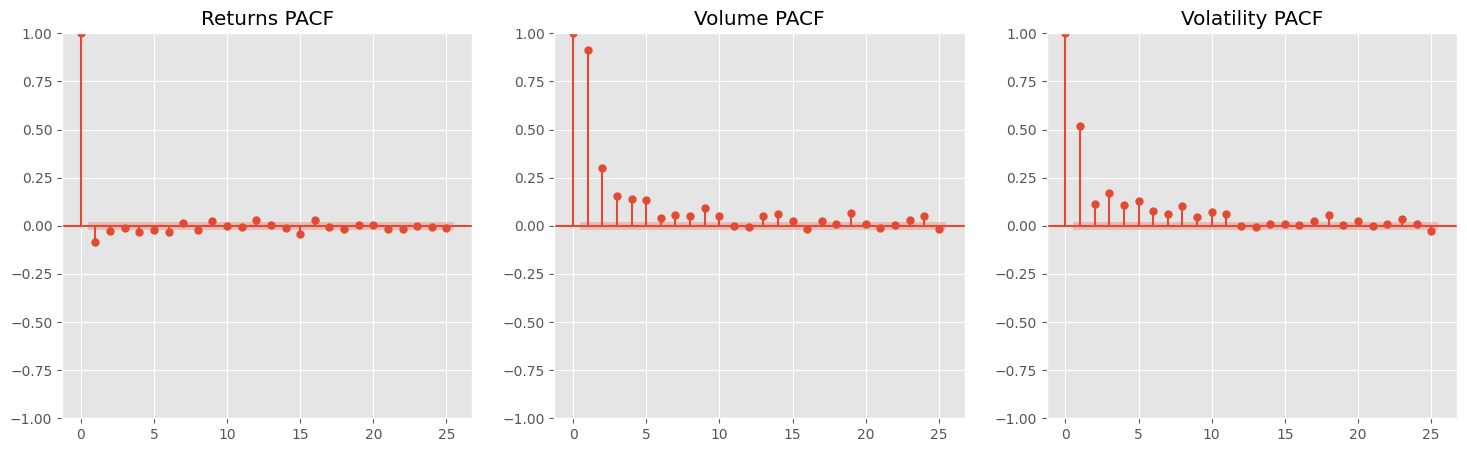

In [165]:
# Plot the partial autocorrelation of the lagged returns, lagged volume, and rolling volatility
N_LAGS = 25

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

plot_pacf(data['Returns'], ax=axes[0], title='Returns PACF', lags=N_LAGS)
plot_pacf(data['Volume'], ax=axes[1],  title='Volume PACF', lags=N_LAGS)
plot_pacf(data['volatility_1'], ax=axes[2],  title='Volatility PACF', lags=N_LAGS)
plt.show()

In [166]:
# Calculate the correlations between the predictors and the daily returns
for col in data.columns:
    if col not in ['Returns', 'Close', 'Volume', 'Direction']:
        correlation = np.corrcoef(data['Returns'], data[col])[0][1]

        print(f'Correlation (Returns, {col}) = {correlation}')

Correlation (Returns, Ret_Lag1) = -0.08286927127452284
Correlation (Returns, Ret_Lag2) = -0.019278253400121775
Correlation (Returns, Ret_Lag3) = -0.008675228347203356
Correlation (Returns, Ret_Lag4) = -0.027853814234927936
Correlation (Returns, Ret_Lag5) = -0.018476283577136023
Correlation (Returns, Vol_Lag1) = 0.003712261123575824
Correlation (Returns, Vol_Lag2) = 0.003933810244768329
Correlation (Returns, Vol_Lag3) = -0.001738611408366749
Correlation (Returns, Vol_Lag4) = 0.0017603735974198024
Correlation (Returns, Vol_Lag5) = -0.0013111429974983536
Correlation (Returns, volatility_1) = 0.048281876524928345
Correlation (Returns, volatility_2) = 0.029550199799797058
Correlation (Returns, volatility_3) = 0.029052068954144906
Correlation (Returns, volatility_4) = 0.022468580081934277
Correlation (Returns, volatility_5) = 0.01866893976277501


The PACF plots for the three general versions of the predictors suggest that there is autocorrelation in the predictors (particularly strong autocorrelation in Volume and Volatility). Futhermore, the correlations between the identified predictors and the daily returns are weak, suggesting there is an insignificant linear relationship between the response and the predictor, justifying the use of the QDA model rather than a linear classifier.

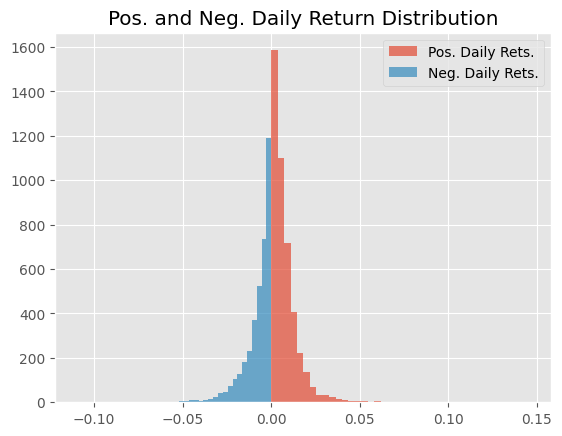

Number of Positive Daily Returns: 4381 | 53.99975348206581%
Number of Negative Daily Returns: 3732 | 46.00024651793418%


In [167]:
# Extract the positive and negative daily returns
positive_rets = data['Returns'][data['Returns'] > 0]
negative_rets = data['Returns'][data['Returns'] <= 0]

# Plot the distributions of the positive and negative daily returns
plt.hist(positive_rets, bins=40, alpha=0.7, label='Pos. Daily Rets.')
plt.hist(negative_rets, bins=40, alpha=0.7, label='Neg. Daily Rets.')
plt.title('Pos. and Neg. Daily Return Distribution')
plt.legend()
plt.show()

print(f'Number of Positive Daily Returns: {len(positive_rets)} | {(len(positive_rets) / len(data)) * 100}%')
print(f'Number of Negative Daily Returns: {len(negative_rets)} | {(len(negative_rets) / len(data)) * 100}%')

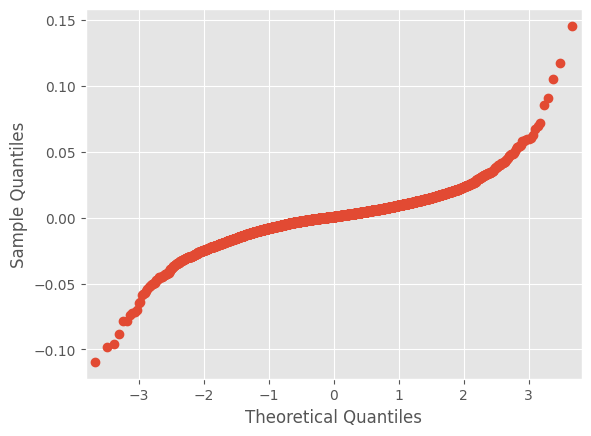

In [168]:
# Q-Q Plot of daily returns
sm.qqplot(data['Returns'])
plt.show()

#### Discussion and Findings
Observing the Q-Q Plot, the pronounced S-curve of the plot indicates that the distribution of daily returns is either skewed or has different tails compared to the normal distribution. As seen in the distribution of daily returns, the distribution is left-skewed, with more positive daily returns. Rougly 54% of the daily returns are positive and 46% of the daily returns are negative. By inspection, the daily return distribution appears to have fat tails with some daily returns around +/-5%. Because QDA assumes predictors are drawn from a normal distribution, the code below tests the predictors for normality.<br>
Null Hypothesis: Data is a normal distribution<br>
Alternative Hypothesis: Data is not a normal distribution

In [169]:
# Test the predictors for normality
alpha = 0.05

# Seperate the predictor columns
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# Group the data into Up and Down classes
grouped = data.groupby('Direction')
for name, group in grouped:
    print(f'Predictor Distributions ({name}) =================')

    for predictor in predictor_columns:
        stat, pval = normaltest(group[predictor])

        if pvalue <= alpha:
            print(f'95% confident that: {predictor} is normally distributed.')
        else:
            print(f'95% confident that: {predictor} is not normally distributed.')

Predictor Distributions (Down) =================
95% confident that: Ret_Lag1 is normally distributed.
95% confident that: Ret_Lag2 is normally distributed.
95% confident that: Ret_Lag3 is normally distributed.
95% confident that: Ret_Lag4 is normally distributed.
95% confident that: Ret_Lag5 is normally distributed.
95% confident that: Vol_Lag1 is normally distributed.
95% confident that: Vol_Lag2 is normally distributed.
95% confident that: Vol_Lag3 is normally distributed.
95% confident that: Vol_Lag4 is normally distributed.
95% confident that: Vol_Lag5 is normally distributed.
95% confident that: volatility_1 is normally distributed.
95% confident that: volatility_2 is normally distributed.
95% confident that: volatility_3 is normally distributed.
95% confident that: volatility_4 is normally distributed.
95% confident that: volatility_5 is normally distributed.
Predictor Distributions (Up) =================
95% confident that: Ret_Lag1 is normally distributed.
95% confident that: 

We can see that all of the predictors appear to be a normal distribution at the 95% confidence interval.

In [170]:
# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

In [171]:
# Check collinearity using the variance inflation factor (VIF)
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

                    VIF
Ret_Lag1       1.081831
Ret_Lag2       1.146635
Ret_Lag3       1.149704
Ret_Lag4       1.134668
Ret_Lag5       1.049462
Vol_Lag1       7.847461
Vol_Lag2       9.802752
Vol_Lag3      10.129378
Vol_Lag4       9.958007
Vol_Lag5       7.962281
volatility_1   3.166395
volatility_2   8.367844
volatility_3  15.961844
volatility_4  25.033600
volatility_5  16.341850


We can see from the VIF values that there are collinear predictors, particularly lagged volume and rolling volatility. To remove the collinearity, each predictor (lagged volume and rolling volatility) will be combined into their own single predictors by taking the mean value of their lagged/rolling period.

In [172]:
# Combine the collinear predictors
data['Lag_Volume'] = data[['Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5']].mean(axis=1)
data['Lag_Volatility'] = data[['volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5']].mean(axis=1)

# Remove the lagged columns
data.drop(columns=[
    'Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)

predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# NOTE: By removing the Lag_Volume and the Lag_Volatility and keeping the one day lagged volume and volatility, the model performs better AND VIF is lower

In [173]:
NON_PREDICTOR_COLS = 2 # Number of non-predictor columns
p = len(data.columns) - NON_PREDICTOR_COLS
n = len(data)

print(f'Ratio of predictors to observations: {p / n}')

# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Check collinearity again using the variance inflation factor (VIF)
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

Ratio of predictors to observations: 0.0009860717367188463
                     VIF
Ret_Lag1        1.012987
Ret_Lag2        1.032529
Ret_Lag3        1.041385
Ret_Lag4        1.046961
Ret_Lag5        1.036181
Lag_Volume      1.243670
Lag_Volatility  1.324029


In [174]:
# Display the basic summary of the data
print(f'Predictor Data Set Shape: {X.shape}')
print(f'Class Distribution: \n{pd.Series(y).value_counts()}')

# NOTE: True is "Up" and False is "Down"

Predictor Data Set Shape: (8113, 8)
Class Distribution: 
Direction
True     4381
False    3732
Name: count, dtype: int64


In [175]:
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

In [176]:
# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

In [177]:
# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down        931   602
Up         2034  2923

QDA: Test Model Performance ==========
Prediction Rate:     0.5938
Training Error:      0.4062
Model Sensitivity:   0.8292
Model Specificity:   0.3140
False Positive Rate: 0.6860
False Negative Rate: 0.1708


From the model's performance metrics, we can see that it correctly predicts the direction of 59.35% daily market moves, on average. The majority of those predictions result from the model's sensitivity, which correctly predicts "Up" almost 83% of the time. The model performs quite poorly when attempting to predict "Down", with corret predictions only 31% of the time.<br><br>
To see if the performance can be enhanced on both "Up" and "Down" predictions, a combination of additional predictors will be used.

---
#### Model 1
This model uses the lagged returns and the first lagged volume.

In [178]:
# Reload the downloaded data
data = test_data.copy()

# Keep only the first lagged volume
data.drop(columns=[
    'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_1', 'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# Seperate predictors and response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Set train and test parameters
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

# Seperate train and test data
X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down        385   393
Up         2580  3132

QDA: Test Model Performance ==========
Prediction Rate:     0.5419
Training Error:      0.4581
Model Sensitivity:   0.8885
Model Specificity:   0.1298
False Positive Rate: 0.8702
False Negative Rate: 0.1115


#### Model 2
This model uses the lagged returns and the first lagged volatility.

In [179]:
# Reload the downloaded data
data = test_data.copy()

# Keep only the first lagged volume
data.drop(columns=[
    'Vol_Lag1', 'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# Seperate predictors and response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Set train and test parameters
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

# Seperate train and test data
X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down       1595   628
Up         1370  2897

QDA: Test Model Performance ==========
Prediction Rate:     0.6921
Training Error:      0.3079
Model Sensitivity:   0.8218
Model Specificity:   0.5379
False Positive Rate: 0.4621
False Negative Rate: 0.1782


#### Model 3
This model uses the lagged returns, first lagged volume, and first lagged volatility.

In [180]:
# Reload the downloaded data
data = test_data.copy()

# Keep only the first lagged volume
data.drop(columns=[
    'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# Seperate predictors and response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

# Set train and test parameters
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

# Seperate train and test data
X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

# Quadratic discriminant analysis (test data)
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down       1596   612
Up         1369  2913

QDA: Test Model Performance ==========
Prediction Rate:     0.6948
Training Error:      0.3052
Model Sensitivity:   0.8264
Model Specificity:   0.5383
False Positive Rate: 0.4617
False Negative Rate: 0.1736


After observing the model's performance, the most promising predictors for the QDA model are the lagged returns and the first lagged volume and first lagged volatility. The prediction rate was over 69% and the false positive rate was reduced to 46.24%. To better assess whether this model has real predictive power in financial markets, further validation needs to be completed using various cross-validation resampling techniques. Additionally, the collinearity and covariances between the predictors needs to be further analyzed to confirm the model is not introducing bias or being overfit to the data. It is also worth investigating whether these predictors are consistent across individual constituents in the market, and across benchmarks indicies.

### 2. Cross-Validation
To better assess the best model's test error rate, LOOCV (leave-one-out cross-validation) will be used. Fitting n-1 QDA models, where n is the number of observations in the data set, we can getter a better estimate of the model's performance compared to the simple validation set approach used above. The model being used is the one that keeps the first lagged volume and first lagged volatility.

In [181]:
# Leave-One-Out Cross Validation
import warnings
warnings.filterwarnings('ignore')

# Reload the data
data = test_data.copy()

errors = []
n = len(data)

# Seperate the predictors and responses
data.drop(columns=[
    'Vol_Lag2', 'Vol_Lag3', 'Vol_Lag4', 'Vol_Lag5',
    'volatility_2', 'volatility_3', 'volatility_4', 'volatility_5'
], inplace=True)

predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

for i in range(n):
    # Split training and test data
    test_data = data.iloc[[i]]                  # ith row only
    train_data = data.drop(index=data.index[i]) # Removed the ith row

    # Extract direction labels
    y_train = train_data['Direction']
    y_test = test_data['Direction'].values[0]

    # Transform predictors
    X_train = MS(predictor_columns).fit_transform(train_data).drop(columns='intercept')
    X_test = MS(predictor_columns).fit_transform(test_data).drop(columns='intercept')

    # Fit QDA and make prediction
    qda = QDA(store_covariance=True)
    qda.fit(X_train, y_train)

    prediction = qda.predict(X_test)

    # Record error
    errors.append(int(prediction[0] != y_test))

# Compute LOOCV error
estimated_error = np.mean(errors)
print(f'Estimated LOOCV Test Error: {estimated_error:.4f}')

Estimated LOOCV Test Error: 0.3047


### 3. Predictor Validation
To see how the predictors in the best QDA model relate to eachother, the code below investigates the distribuions of predictors belonging to each class, collinearity between the predictors, and the covariance matrices of the predictors. The analysis is done on the predictors identified to produce the lowest estimated test error (5-day return lags, 1-day lagged volume, 1-period lagged volatility).

                   VIF
Ret_Lag2      1.023017
Ret_Lag3      1.020767
Ret_Lag4      1.020063
Ret_Lag5      1.010973
Vol_Lag1      1.707660
volatility_1  1.728044


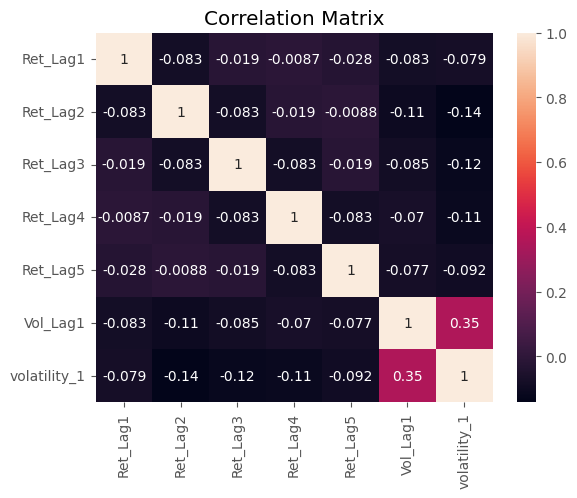

In [182]:
# Check collinearity using the variance inflation factor (VIF)
X = MS(predictor_columns).fit_transform(data).drop(columns='intercept')

vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

corr = data[predictor_columns].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix')
plt.show()

Down - Rank: 1 | Shape: (7, 7)
Down - Unique Rows: 3732
Up - Rank: 1 | Shape: (7, 7)
Up - Unique Rows: 4381


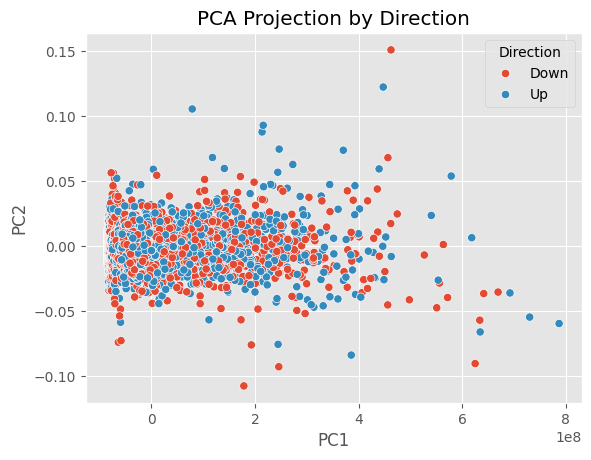

{'James T^2': 1.170479180221037, 'df': 110.59046809738258, 'p-value': 1.0}


In [183]:
# Check the covariance matrices across predictors

# Group the data into Up and Down classes
grouped = data.groupby('Direction')
for name, group in grouped:
    # Calculate the rank
    cov = np.cov(group[predictor_columns].T)
    rank = np.linalg.matrix_rank(cov)

    # Calculate the number of unique rows (per class)
    unique_rows = group[predictor_columns].drop_duplicates().shape[0]

    print(f'{name} - Rank: {rank} | Shape: {cov.shape}')
    print(f'{name} - Unique Rows: {unique_rows}')

# Use Principal Component Analysis to see if each group is concentrated along a single axis
pca = PCA(n_components=2)
components = pca.fit_transform(data[predictor_columns])
data[['PC1', 'PC2']] = components

sns.scatterplot(data=data, x='PC1', y='PC2', hue='Direction')
plt.title('PCA Projection by Direction')
plt.show()

def james_test(group1, group2):
    """
    Perform James's test for equality of mean vectors when covariance matrices may be unequal or singular.

    Parameters:
    - group1: pd.DataFrame of shape (n1, p)
    - group2: pd.DataFrame of shape (n2, p)

    Returns:
    - Dictionary with James T^2 statistic, degrees of freedom, and p-value
    """
    n1, p = group1.shape
    n2 = group2.shape[0]

    # Sample covariance matrices
    S1 = np.cov(group1, rowvar=False)
    S2 = np.cov(group2, rowvar=False)

    # Sample means
    x1_bar = np.mean(group1, axis=0)
    x2_bar = np.mean(group2, axis=0)

    # Pooled covariance estimate using generalized inverse
    Sp = (S1 / n1) + (S2 / n2)
    Sp_inv = pinv(Sp)  # Generalized inverse in case of singularity

    # Difference in means
    mean_diff = x1_bar - x2_bar

    # James's T² statistic
    T2 = mean_diff @ Sp_inv @ mean_diff.T

    # Approximate degrees of freedom
    trace_term = np.trace((S1 / n1) @ Sp_inv @ (S1 / n1) @ Sp_inv) + np.trace((S2 / n2) @ Sp_inv @ (S2 / n2) @ Sp_inv)
    df = (p ** 2 + p) / trace_term if trace_term > 0 else np.inf

    # Chi-squared p-value
    p_value = 1 - chi2.cdf(T2, df)

    return {"James T^2": T2, "df": df, "p-value": p_value}

# Check the equivalence of the covariance matrices using the James's Test
g1 = data[data['Direction'] == 'Up'][predictor_columns]
g2 = data[data['Direction'] == 'Down'][predictor_columns]

result = james_test(g1, g2)

print(result)

James's test was used over Box's M test due to the rank of the covariance matrices. James's test tests for equality of the covariance matrices when they may be unequal or near-singular and does not assume mormality. Becasue the rank of the covariance matrices appear to be singular, this test is required.

### 4. Historical Backtest Performance

### 5. Application to Additional Constituents

### 6. Additional Predictors